<a href="https://colab.research.google.com/github/potatolover68/stuff/blob/main/notebooks/projector_image_processing_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# projector image processing

given following:
* `s_x` and `s_y`, size of rectangular plane to project to. x axis is left-and-right, y axis is bottom-and-top, and z axis is down-and-up(negative is down, positive is up, etc)
* `p1_x`, `p1_y`, `p1_z`, `p1_pitch`, and `p2_x`, `p2_y`, `p2_z`, `p2_pitch`, XYZ offset from the midpoint of the top-and-bottom y-axis edge's midpoint, equiv. to the local position of that projector from the y-axis edge's midpoint. Pitch is offset, a pitch of 0 means it is looking parallel to the ground, a pitch of -90 means it is looking perpendicular to the ground.
* `f` is the feathering distance of each projector, starting from the midpoint of s_x, parallel to s_y, and out on both sides
* `t` is the throw ratio of both projectors

In [114]:

s_x, s_y = 85, 50 # high school basketball court size
p1_x, p1_y, p1_z = -23.75, 0, 45 # has to be 45ft up
p1_pitch = -90

p2_x, p2_y, p2_z = -23.75, 0, 45 # same thing
p2_pitch = -90

f = 5
t = 0.75

In [ ]:
# Resize input image to match court aspect ratio
from PIL import Image as PILImage
from pathlib import Path

def prepare_input_image(input_path: str, output_path: str = None):
    """
    Resizes input image to match s_x:s_y aspect ratio without clipping.
    Adds letterboxing/pillarboxing if needed.
    """
    if output_path is None:
        output_path = Path(input_path).stem + "_resized.jpg"
    
    img = PILImage.open(input_path)
    img_w, img_h = img.size
    
    # Target aspect ratio from court dimensions
    target_aspect = s_x / s_y
    current_aspect = img_w / img_h
    
    print(f"Original: {img_w}×{img_h} (aspect {current_aspect:.3f})")
    print(f"Target aspect: {target_aspect:.3f} (from {s_x}×{s_y} court)")
    
    if abs(current_aspect - target_aspect) < 0.01:
        print("Image already matches target aspect ratio!")
        img.save(output_path)
        return output_path
    
    # Determine target size to fit the image without cropping
    if current_aspect > target_aspect:
        # Image is wider - fit to width, add top/bottom bars
        target_w = img_w
        target_h = int(img_w / target_aspect)
    else:
        # Image is taller - fit to height, add left/right bars
        target_h = img_h
        target_w = int(img_h * target_aspect)
    
    # Create new image with letterboxing/pillarboxing
    new_img = PILImage.new('RGB', (target_w, target_h), (0, 0, 0))
    
    # Paste original centered
    paste_x = (target_w - img_w) // 2
    paste_y = (target_h - img_h) // 2
    new_img.paste(img, (paste_x, paste_y))
    
    new_img.save(output_path)
    print(f"Saved: {output_path} at {target_w}×{target_h}")
    return output_path

# Prepare the input image
resized_path = prepare_input_image("testimage.jpg")



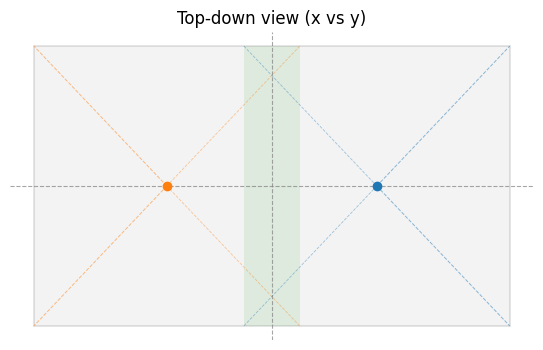

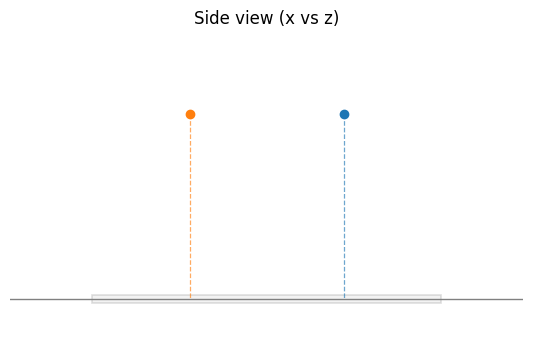

In [115]:
def direction_from_pitch(pitch_deg: float) -> np.ndarray:
    rad = np.deg2rad(pitch_deg)
    return np.array([0.0, np.cos(rad), np.sin(rad)])  # x, y, z components

# simple intersection of ray (p + t*d) with ground plane z=0
# returns None if dir_z is ~0 or intersection is behind the projector
EPS = 1e-6
def intersect_ground(origin: np.ndarray, direction: np.ndarray):
    if abs(direction[2]) < EPS:
        return None
    t = -origin[2] / direction[2]
    if t < 0:
        return None
    return origin + t * direction

# Each projector is positioned relative to the midpoint of its side's y-edge:
# P1 uses the left edge midpoint; P2 uses the right edge midpoint.
edge_mid_left = np.array([-s_x / 2, 0.0, 0.0])
edge_mid_right = np.array([s_x / 2, 0.0, 0.0])

projectors = [
    # P1: x-axis mirrored (positive means further left), so negate the x offset in world coords
    {"pos": edge_mid_left + np.array([-p1_x, p1_y, p1_z]), "pitch": p1_pitch, "color": "tab:orange", "x_sign": -1},
    {"pos": edge_mid_right + np.array([p2_x, p2_y, p2_z]), "pitch": p2_pitch, "color": "tab:blue", "x_sign": 1},
]

# Top-down view (x vs y)
fig, ax = plt.subplots(figsize=(8, 4))
plane_rect = plt.Rectangle((-s_x / 2, -s_y / 2), s_x, s_y, linewidth=1.2, edgecolor="gray", facecolor="lightgray", alpha=0.25)
feather_band = plt.Rectangle((-f, -s_y / 2), 2 * f, s_y, linewidth=0, facecolor="tab:green", alpha=0.1)
ax.add_patch(plane_rect)
ax.add_patch(feather_band)
# center reference lines
ax.axvline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

for p, edge_corners in zip(projectors, [[(-s_x/2, -s_y/2), (-s_x/2, s_y/2)], [(s_x/2, -s_y/2), (s_x/2, s_y/2)]]):
    pos_xy = p["pos"][:2]
    dir_vec = direction_from_pitch(p["pitch"])
    hit = intersect_ground(p["pos"], dir_vec)
    ax.scatter(*pos_xy, color=p["color"], zorder=5)
    ax.quiver(*pos_xy, dir_vec[0], dir_vec[1], angles="xy", scale_units="xy", scale=1, width=0.004, color=p["color"], alpha=0.9, zorder=6)
    ax.plot([pos_xy[0], pos_xy[0] + dir_vec[0]], [pos_xy[1], pos_xy[1] + dir_vec[1]], color=p["color"], alpha=0.9, linewidth=1.1, zorder=6)
    if hit is not None:
        ax.plot([pos_xy[0], hit[0]], [pos_xy[1], hit[1]], color=p["color"], alpha=0.65, linestyle="--", linewidth=0.9, zorder=4)
    # thin dashed lines to edges (same side)
    for corner in edge_corners:
        ax.plot([pos_xy[0], corner[0]], [pos_xy[1], corner[1]], color=p["color"], alpha=0.5, linestyle="--", linewidth=0.7, zorder=3)
    # thin dashed lines to far-side feather edge (top/bottom points at opposite feather boundary)
    far_feather_x = f if pos_xy[0] < 0 else -f
    far_targets = [(far_feather_x, -s_y/2), (far_feather_x, s_y/2)]
    for corner in far_targets:
        ax.plot([pos_xy[0], corner[0]], [pos_xy[1], corner[1]], color=p["color"], alpha=0.4, linestyle="--", linewidth=0.6, zorder=2)

ax.set_aspect("equal")
ax.axis("off")
ax.set_title("Top-down view (x vs y)")

# Side view (x vs z)
fig, ax = plt.subplots(figsize=(8, 4))
plane_strip = plt.Rectangle((-s_x / 2, -1), s_x, 2, linewidth=1.2, edgecolor="gray", facecolor="lightgray", alpha=0.25)
ax.add_patch(plane_strip)
ax.axhline(0, color="gray", linewidth=1)
for p in projectors:
    pos_xz = np.array([p["pos"][0], p["pos"][2]])
    dir_vec = direction_from_pitch(p["pitch"])
    hit = intersect_ground(p["pos"], dir_vec)
    ax.scatter(pos_xz[0], pos_xz[1], color=p["color"], zorder=5)
    ax.quiver(pos_xz[0], pos_xz[1], dir_vec[0], dir_vec[2], angles="xy", scale_units="xy", scale=1, width=0.004, color=p["color"], alpha=0.9, zorder=6)
    ax.plot([pos_xz[0], pos_xz[0] + dir_vec[0]], [pos_xz[1], pos_xz[1] + dir_vec[2]], color=p["color"], alpha=0.9, linewidth=1.1, zorder=6)
    if hit is not None:
        ax.plot([pos_xz[0], hit[0]], [pos_xz[1], hit[2]], color=p["color"], alpha=0.65, linestyle="--", linewidth=0.9, zorder=4)
ax.set_xlim(-s_x / 2 - 20, s_x / 2 + 20)
ax.set_ylim(-10, max(p1_z, p2_z) + 20)
ax.set_aspect("equal")
ax.axis("off")
ax.set_title("Side view (x vs z)")

plt.show()


In [116]:
# Generate per-projector distance^2 BMPs and feather masks
from pathlib import Path
from PIL import Image

def make_distance_and_feather_images(scale: int = 1):
    """Generate distance and feather BMPs. scale=4 samples 4x more pixels in each dimension."""
    width = int((s_x / 2 + f) * scale)
    height = int(s_y * scale)
    ys = np.linspace(-s_y / 2, s_y / 2, height)
    out_dir = Path("outputs")
    out_dir.mkdir(exist_ok=True)

    projector_defs = [
        ("left", projectors[0], np.linspace(-s_x / 2, f, width)),
        ("right", projectors[1], np.linspace(-f, s_x / 2, width)),
    ]

    for side, proj, xs in projector_defs:
        grid_x, grid_y = np.meshgrid(xs, ys)
        pts = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=-1)
        dist2 = np.sum((pts - proj["pos"]) ** 2, axis=-1)
        dist2_max = dist2.max()
        dist_norm = dist2 if dist2_max == 0 else dist2 / dist2_max
        # Farther = brighter (to compensate for inverse square law)
        dist_img = np.clip(dist_norm * 255, 0, 255).astype(np.uint8)

        # Feather mask: white everywhere; linear white->black across the feather band toward center
        if side == "left":
            weights = np.where(xs >= 0, 1 - (xs / f), 1.0)
        else:  # right projector
            weights = np.where(xs <= 0, 1 - (np.abs(xs) / f), 1.0)
        weights = np.clip(weights, 0, 1)
        feather_img = (np.repeat(weights[None, :], height, axis=0) * 255).astype(np.uint8)

        Image.fromarray(dist_img, mode="L").save(out_dir / f"distance_{side}.bmp")
        Image.fromarray(feather_img, mode="L").save(out_dir / f"feather_{side}.bmp")
        
        # Composite: distance * feather (both normalized to 0-1)
        dist_norm = dist_img.astype(np.float32) / 255.0
        feather_norm = feather_img.astype(np.float32) / 255.0
        composite = (dist_norm * feather_norm * 255).astype(np.uint8)
        Image.fromarray(composite, mode="L").save(out_dir / f"composite_{side}.bmp")
        
        print(f"Saved distance_{side}.bmp, feather_{side}.bmp, composite_{side}.bmp -> {width}x{height}")

make_distance_and_feather_images(scale=24)



Saved distance_left.bmp, feather_left.bmp, composite_left.bmp -> 1140x1200
Saved distance_right.bmp, feather_right.bmp, composite_right.bmp -> 1140x1200


In [117]:
# Process input image for projection mapping
def process_image_for_projection(input_path: str, scale: int = 4, brightness_multiplier: float = 1.0):
    """
    Takes a 16x9 image, splits it for left/right projectors, applies feathering and geometric correction.
    brightness_multiplier: scale output brightness (clamped to 0-255)
    """
    from PIL import Image as PILImage
    
    # Load input image
    img = PILImage.open(input_path).convert("RGB")
    img_array = np.array(img).astype(np.float32) / 255.0
    img_h, img_w = img_array.shape[:2]
    
    out_dir = Path("outputs")
    out_dir.mkdir(exist_ok=True)
    
    # Output dimensions match our generated BMPs
    width = int((s_x / 2 + f) * scale)
    height = int(s_y * scale)
    
    projector_configs = [
        ("left", projectors[0], np.linspace(-s_x / 2, f, width), 0, 0.5),  # maps to left half + feather
        ("right", projectors[1], np.linspace(-f, s_x / 2, width), 0.5, 1.0),  # maps to right half + feather
    ]
    
    for side, proj, xs, src_x_start, src_x_end in projector_configs:
        ys = np.linspace(-s_y / 2, s_y / 2, height)
        grid_x, grid_y = np.meshgrid(xs, ys)
        
        # Load composite mask for this projector and ensure it matches our grid size
        composite_img = PILImage.open(out_dir / f"composite_{side}.bmp")
        if composite_img.size != (width, height):
            composite_img = composite_img.resize((width, height), PILImage.BILINEAR)
        composite = np.array(composite_img).astype(np.float32) / 255.0
        
        # Map world coordinates to source image coordinates
        # x maps to horizontal position in source image
        # For overlapping feather region, both projectors see the middle portion
        x_norm = np.zeros_like(grid_x)
        if side == "left":
            # -s_x/2 to f: map to 0.0 to 0.5 + (f / s_x)
            x_norm = (grid_x + s_x / 2) / (s_x / 2 + f) * (0.5 + f / s_x)
        else:  # right
            # -f to s_x/2: map to 0.5 - (f / s_x) to 1.0
            x_norm = (grid_x + f) / (s_x / 2 + f) * (0.5 + f / s_x) + (0.5 - f / s_x)
        
        y_norm = (grid_y + s_y / 2) / s_y
        
        # Apply projector perspective distortion
        # Ray from projector through each ground point
        pts_3d = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=-1)
        proj_pos = proj["pos"]
        
        # Vector from projector to point
        ray_vec = pts_3d - proj_pos
        ray_len = np.linalg.norm(ray_vec, axis=-1, keepdims=True)
        ray_vec_norm = ray_vec / (ray_len + 1e-9)
        
        # Apply pitch-based distortion factor (distance affects apparent size)
        # Points farther from projector appear smaller in projection
        distortion_factor = ray_len.squeeze() / ray_len.max()
        
        # Sample from source image with distortion
        x_coords = np.clip(x_norm * (img_w - 1), 0, img_w - 1).astype(np.int32)
        y_coords = np.clip(y_norm * (img_h - 1), 0, img_h - 1).astype(np.int32)
        
        sampled = img_array[y_coords, x_coords]
        
        # Apply composite mask (feathering + distance)
        output = sampled * composite[..., None]
        
        # Apply brightness multiplier
        output = output * brightness_multiplier
        output = np.clip(output * 255, 0, 255).astype(np.uint8)
        
        PILImage.fromarray(output, mode="RGB").save(out_dir / f"output_{side}.bmp")
        print(f"Saved output_{side}.bmp -> {width}x{height}")

        
process_image_for_projection("testimage.jpg", scale=12, brightness_multiplier=1.0)

Saved output_left.bmp -> 570x600
Saved output_right.bmp -> 570x600


In [ ]:
# Apply geometric distortion based on projector throw ratio and angle (VECTORIZED - FAST!)
def create_projection_warped_images(input_path: str, output_width: int = 1920, output_height: int = 1080, brightness_mult: float = 1.0):
    """
    Creates geometrically distorted images for each projector accounting for throw ratio and pitch.
    output_width, output_height: projector native resolution
    """
    from PIL import Image as PILImage
    
    img = PILImage.open(input_path).convert("RGB")
    img_array = np.array(img).astype(np.float32) / 255.0
    img_h, img_w = img_array.shape[:2]
    
    out_dir = Path("outputs")
    out_dir.mkdir(exist_ok=True)
    
    # For each projector
    for side, proj in [("left", projectors[0]), ("right", projectors[1])]:
        print(f"Processing {side} projector...")
        
        # Load composite for this projector
        composite = np.array(PILImage.open(out_dir / f"composite_{side}.bmp")).astype(np.float32) / 255.0
        
        proj_pos = proj["pos"]
        pitch_rad = np.deg2rad(proj["pitch"])
        
        # Create grid of normalized pixel coordinates [-0.5, 0.5] for 16:9 aspect
        u = np.linspace(-0.5, 0.5, output_width)
        v = np.linspace(-0.5 * 9/16, 0.5 * 9/16, output_height)
        u_grid, v_grid = np.meshgrid(u, v)
        
        # Throw ratio: distance / image_width, so at height h, width = h/t
        # Field of view angle: tan(fov/2) = (w/2) / d = 1/(2*t)
        # For each normalized coord u_norm in [-0.5, 0.5], angle = atan(u_norm / t)
        
        # Ray directions in projector local space (before pitch rotation)
        # In projector coords: x=right, y=forward (optical axis), z=up
        ray_local_x = u_grid / t
        ray_local_y = np.ones_like(u_grid)  # forward = 1 unit
        ray_local_z = v_grid / t
        
        # Normalize
        ray_len_local = np.sqrt(ray_local_x**2 + ray_local_y**2 + ray_local_z**2)
        ray_local_x = ray_local_x / ray_len_local
        ray_local_y = ray_local_y / ray_len_local
        ray_local_z = ray_local_z / ray_len_local
        
        # Rotate by pitch: rotation around x-axis
        # New y = y*cos - z*sin, New z = y*sin + z*cos
        cos_p = np.cos(pitch_rad)
        sin_p = np.sin(pitch_rad)
        ray_y_rot = ray_local_y * cos_p - ray_local_z * sin_p
        ray_z_rot = ray_local_y * sin_p + ray_local_z * cos_p
        ray_x = ray_local_x  # x unchanged by pitch rotation
        
        # Intersect with ground plane (z=0) - vectorized
        t_hit = -proj_pos[2] / ray_z_rot
        valid = (np.abs(ray_z_rot) > 1e-6) & (t_hit > 0)
        
        hit_x = proj_pos[0] + t_hit * ray_x
        hit_y = proj_pos[1] + t_hit * ray_y_rot
        
        # Initialize output
        warped = np.zeros((output_height, output_width, 3), dtype=np.float32)
        
        # Map to source image coordinates (expand bounds to account for full FOV)
        if side == "left":
            # Expand bounds beyond strict rectangle to capture full projection FOV
            x_norm = (hit_x + s_x/2) / (s_x/2 + f) * (0.5 + f/s_x)
            y_norm = (hit_y + s_y/2) / s_y
            comp_x_norm = (hit_x + s_x/2) / (s_x/2 + f)
            comp_y_norm = (hit_y + s_y/2) / s_y
            # Only filter composite coordinates (allow source to go beyond)
            valid = valid & (comp_x_norm >= 0) & (comp_x_norm <= 1) & (comp_y_norm >= 0) & (comp_y_norm <= 1)
        else:  # right
            x_norm = (hit_x + f) / (s_x/2 + f) * (0.5 + f/s_x) + (0.5 - f/s_x)
            y_norm = (hit_y + s_y/2) / s_y
            comp_x_norm = (hit_x + f) / (s_x/2 + f)
            comp_y_norm = (hit_y + s_y/2) / s_y
            # Only filter composite coordinates (allow source to go beyond)
            valid = valid & (comp_x_norm >= 0) & (comp_x_norm <= 1) & (comp_y_norm >= 0) & (comp_y_norm <= 1)
        
        # Clamp coordinates
        src_x = np.clip(x_norm * (img_w - 1), 0, img_w - 1).astype(np.int32)
        src_y = np.clip(y_norm * (img_h - 1), 0, img_h - 1).astype(np.int32)
        comp_x = np.clip(comp_x_norm * (composite.shape[1] - 1), 0, composite.shape[1] - 1).astype(np.int32)
        comp_y = np.clip(comp_y_norm * (composite.shape[0] - 1), 0, composite.shape[0] - 1).astype(np.int32)
        
        # Sample and apply composite (only where valid) - VECTORIZED
        warped[valid] = img_array[src_y[valid], src_x[valid]] * composite[comp_y[valid], comp_x[valid]][:, None]
        
        # Apply brightness and save
        warped = warped * brightness_mult
        warped = np.clip(warped * 255, 0, 255).astype(np.uint8)
        PILImage.fromarray(warped, mode="RGB").save(out_dir / f"warped_{side}.bmp")
        print(f"Saved warped_{side}.bmp -> {output_width}x{output_height}")

# Example usage (use the resized image):
# create_projection_warped_images("testimage_resized.jpg", output_width=1920, output_height=1080, brightness_mult=1.0)



Processing left projector...
Saved warped_left.bmp -> 1920x1080
Processing right projector...
Saved warped_right.bmp -> 1920x1080
